In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import time
import json
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from multiprocessing import Pool
import lightgbm as lgb
from tqdm.notebook import tqdm
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])

available GPU devices: 1  | device num: 0


In [2]:
SEED = 80
DATA_DIR = './data'
MODELS_DIR = './models'
MODEL_VER = 'v0'
CUT_DATE = '2011-01-01'
END_D = 1913
PRED_FWD = 28
N_CORES = int(psutil.cpu_count() * .75)
print('num pf cores:', N_CORES)
#---|CUT_DATE|---train---|END_D - PRED_FWD|--val--|END_D|--forecast-->|END_D + PRED_FWD|

num pf cores: 24


In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int8', 
    'month':            'int8', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int8', 
    'snap_TX':          'int8', 
    'snap_WI':          'int8'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float16'
}
DROP_COLS = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday']
CAT_COLS = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]

In [4]:
def get_df():
    start_time = time.time()
    print('-' * 10, 'BASE GRID', '-' * 10)
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    for day in range(END_D + 1, END_D + PRED_FWD + 1):
        strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    strain.drop(columns=['month', 'year'], inplace=True)
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('calendar merge done:', strain.shape)
    strain['tm_d'] = strain['date'].dt.day.astype(np.int8)
    strain['tm_w'] = strain['date'].dt.week.astype(np.int8)
    strain['tm_m'] = strain['date'].dt.month.astype(np.int8)
    strain['tm_y'] = strain['date'].dt.year
    strain['tm_y'] = (strain['tm_y'] - strain['tm_y'].min()).astype(np.int8)
    strain['tm_wm'] = strain['tm_d'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    strain['tm_dw'] = strain['date'].dt.dayofweek.astype(np.int8)
    strain['tm_w_end'] = (strain['tm_dw'] >= 5).astype(np.int8)
    print('date features done')
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    sprices['price_max'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('max')
    sprices['price_min'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('min')
    sprices['price_std'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('std')
    sprices['price_mean'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')
    sprices['price_norm'] = sprices['sell_price'] / sprices['price_max']
    sprices['price_nunique'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('nunique')
    sprices['item_nunique'] = sprices.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')
    calendar_prices = calendar[['wm_yr_wk', 'month', 'year']]
    calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
    sprices = sprices.merge(calendar_prices[['wm_yr_wk', 'month', 'year']], on=['wm_yr_wk'], how='left')
    del calendar, calendar_prices
    sprices['price_momentum'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id']
    )['sell_price'].transform(lambda x: x.shift(1))
    sprices['price_momentum_m'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'month']
    )['sell_price'].transform('mean')
    sprices['price_momentum_y'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'year']
    )['sell_price'].transform('mean')
    strain = strain.merge(sprices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    strain.drop(columns=['month', 'year'], inplace=True)
    del sprices
    strain['lag_price_1'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    strain['price_change_1'] = (strain['lag_price_1']-strain['sell_price']) / strain['lag_price_1']
    strain['roll_price_max_365'] = strain.groupby(['id'])['sell_price'].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    strain['price_change_365'] = (strain['roll_price_max_365']-strain['sell_price']) / strain['roll_price_max_365']
    strain['roll_price_std_7'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    strain['roll_price_std_30'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    print('prices features and merge done:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    for col in CAT_COLS:
        strain[col]= strain[col].astype('category')
        strain[col] = strain[col].cat.codes.astype('int16')
        strain[col] -= strain[col].min()
    print('cols to category done:', strain.shape)
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    gc.collect()
    return strain

In [5]:
def make_features_adv(strain):
    start_time = time.time()
    print('-' * 10, 'ADVANCED FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    icols =  [
        ['state_id'],
        ['store_id'],
        ['cat_id'],
        ['dept_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'cat_id'],
        ['store_id', 'dept_id'],
        ['item_id'],
        ['item_id', 'state_id'],
        ['item_id', 'store_id']
    ]
    cols = list(set([item for sublist in icols for item in sublist]))
    cols.extend(['d', 'sales'])
    df_temp = strain[cols].copy()
    df_temp.loc[df_temp['d'] > (END_D - PRED_FWD), 'sales'] = np.nan
    for col in icols:
        col_name = '_{}_'.format('_'.join(col))
        strain['enc{}mean'.format(col_name)] = df_temp.groupby(col)['sales'].transform('mean').astype(np.float16)
        strain['enc{}std'.format(col_name)] = df_temp.groupby(col)['sales'].transform('std').astype(np.float16)
    print('encoding done')
    del df_temp
    gc.collect()
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [6]:
def make_features_lag(strain):
    start_time = time.time()
    print('-' * 10, 'LAG AND ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = range(PRED_FWD, PRED_FWD + 14 + 1)
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby(['id'])['sales'].shift(lag).astype(np.float16)
    print('lag sales done')
    for roll in [7, 14, 30, 60, 180]:
        roll_col = 'lag_{}_roll_mean_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).mean()
        ).astype(np.float16)
        roll_col = 'lag_{}_roll_std_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).std()
        ).astype(np.float16)
    print('roll mean and std sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [7]:
def make_features_last_sales(strain):
    start_time = time.time()
    print('-' * 10, 'LAST SALES FEATURE', '-' * 10)
    print('in dataframe:', strain.shape)
    n_day = 1    
    last_sales = strain[['id', 'd', 'sales']].copy()
    last_sales['non_zero'] = (last_sales['sales'] > 0).astype(np.int8)
    last_sales['non_zero_lag'] = last_sales.groupby(['id'])['non_zero'].transform(
        lambda x: x.shift(n_day).rolling(2000, 1).sum()
    ).fillna(-1)
    df_temp = last_sales[['id', 'd', 'non_zero_lag']].drop_duplicates(subset=['id', 'non_zero_lag'])
    df_temp.columns = ['id', 'd_min', 'non_zero_lag']
    last_sales = last_sales.merge(df_temp, on=['id', 'non_zero_lag'], how='left')
    strain.loc[:, 'last_sale'] = (last_sales['d'] - last_sales['d_min']).astype(np.int16)
    del last_sales, df_temp
    gc.collect()
    print('last non zero sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [8]:
def make_features_win(strain):
    start_time = time.time()
    print('-' * 10, 'WIN ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = [1, 7, 14]
    windows= [7, 14, 30, 60]
    for lag in lags:
        for wnd in windows:
            wnd_col = 'lag_{}_roll_mean_{}'.format(lag, wnd)
            strain[wnd_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
                lambda x: x.shift(lag).rolling(wnd).mean().astype(np.float16)
            )
    print('window roll mean sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [9]:
%%time
strain = get_df()
strain = make_features_adv(strain)
strain = make_features_lag(strain)
strain = make_features_last_sales(strain)
strain = make_features_win(strain)
strain.to_pickle('{}/strain.pkl'.format(DATA_DIR))

---------- BASE GRID ----------
read train: (30490, 1919)
melted train: (59181090, 8)
time elapsed: 0 min 10 sec
read calendar: (1969, 14)
calendar merge done: (59181090, 19)
date features done
time elapsed: 2 min 8 sec
read prices: (6841121, 4)
prices features and merge done: (59181090, 43)
time elapsed: 4 min 53 sec
cols to category done: (59181090, 43)
begin train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
date cut train: (59181090, 43)
cut train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
time elapsed: 5 min 32 sec
---------- ADVANCED FEATURES ----------
in dataframe: (59181090, 43)
encoding done
time elapsed: 0 min 34 sec
---------- LAG AND ROLL FEATURES ----------
in dataframe: (59181090, 65)
lag sales done
roll mean and std sales done
out dataframe: (59181090, 90)
time elapsed: 6 min 57 sec
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 90)
last non zero sales done
out dataframe: (59181090, 91)
time elapsed: 0 min 56 sec
--

In [9]:
strain = pd.read_pickle('{}/strain.pkl'.format(DATA_DIR))

from 2011-01-29 00:00:00 to 2016-05-22 00:00:00


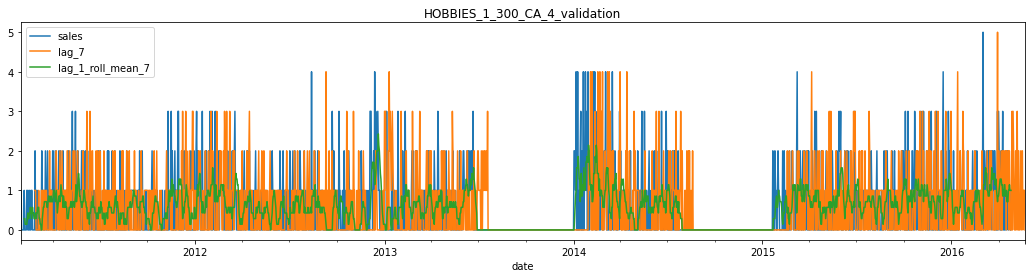

In [10]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_28'].plot(label='lag_7')
id_sales['lag_1_roll_mean_7'].plot(label='lag_1_roll_mean_7')
plt.title(id_name)
plt.legend()
plt.show()
del id_sales

In [11]:
train_cols = strain.columns[~strain.columns.isin(DROP_COLS)]
store_ids = list(strain['store_id'].unique())
print('stores:', store_ids)

stores: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [12]:
def get_train_val(strain, val_d, end_d):
    X_train = strain[(strain['d'] <= end_d) & 
                     (strain['store_id'] == store_id)][train_cols]
    y_train = strain[(strain['d'] <= end_d) & 
                     (strain['store_id'] == store_id)]['sales']
    X_val = strain[(strain['d'] > val_d) & 
                   (strain['d'] <= end_d) & 
                   (strain['store_id'] == store_id)][train_cols]
    y_val = strain[(strain['d'] > val_d) & 
                   (strain['d'] <= end_d) & 
                   (strain['store_id'] == store_id)]['sales']
    return X_train, y_train, X_val, y_val

In [29]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': .5,
    'subsample_freq': 1,
    'learning_rate': .03,
    'num_leaves': 2 ** 11 - 1,
    'min_data_in_leaf': 2 ** 12 - 1,
    'feature_fraction': .5,
    'max_bin': 100,
    'n_estimators': 1400,
    'boost_from_average': False,
    'verbose': 1,
    'nthread' : N_CORES,
    'early_stopping_rounds': 100,
    'lambda_l2': 1.,
    'seed': SEED
}
space = {
    'tweedie_variance_power': hp.quniform('tweedie_variance_power', 1.05, 1.95, .05),
    'learning_rate': hp.quniform('learning_rate', .01, .07, .01),
    'subsample': hp.quniform('subsample', .5, 1, .05),
    'max_depth': hp.choice('max_depth', np.arange(1, 11, dtype=int)),
    'lambda_l2': hp.quniform('lambda_l2', .1, 10, .1)
}
MAX_EVALS = 20

In [ ]:
for store_id in tqdm(store_ids):
    print('=' * 10, 'STORE TRAINING:', store_id, '=' * 10)
    X_train, y_train, X_val, y_val = get_train_val(
        strain, 
        val_d=END_D - 2 * PRED_FWD,
        end_d=END_D - PRED_FWD
    )
    print('hopt train shapes:', X_train.shape, len(y_train))
    print('hopt val shapes:', X_val.shape, len(y_val))
    train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_COLS, free_raw_data=False)
    val_lgb = lgb.Dataset(X_val, label=y_val, categorical_feature=CAT_COLS, free_raw_data=False)
    del X_train, y_train
    print('-' * 10, 'store params hopt search:', store_id, '-' * 10)
    lgb_params_store = lgb_params.copy()
    def objective(params):
        lgb_params_store.update(params)
        model = lgb.LGBMRegressor(**lgb_params)
        model = lgb.train(lgb_params_store, train_lgb, valid_sets=[val_lgb], verbose_eval=100)
        y_true = y_val.values
        y_pred = model.predict(X_val[train_cols])
        score = mean_squared_error(y_true, y_pred) ** .5
        return score
    best_hopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=MAX_EVALS)
    print('store:', store_id, '| best params:', best_hopt)
    lgb_params_store.update(best_hopt)
    params_file = '{}/model_{}_store_{}_best_params.txt'.format(MODELS_DIR, MODEL_VER, store_id)
    with open(params_file, 'w') as file:
        file.write(json.dumps(lgb_params_store))
    del X_val, y_val
    print('-' * 10, 'store best params training:', store_id, '-' * 10)
    X_train, y_train, X_val, y_val = get_train_val(
        strain, 
        val_d=END_D - PRED_FWD,
        end_d=END_D
    )
    print('train shapes:', X_train.shape, len(y_train))
    print('val shapes:', X_val.shape, len(y_val))
    train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_COLS, free_raw_data=False)
    val_lgb = lgb.Dataset(X_val, label=y_val, categorical_feature=CAT_COLS, free_raw_data=False)
    del X_train, y_train, X_val, y_val
    gc.collect()
    model = lgb.train(lgb_params_store, train_lgb, valid_sets=[val_lgb], verbose_eval=100) 
    model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
    model.save_model(model_file)
    print('save to file:', model_file)

========== STORE TRAINING: 0 ==========
hopt train shapes: (5747365, 97) 5747365
hopt val shapes: (85372, 97) 85372
---------- store params hopt search: 0 ----------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.10157                       
[200]	valid_0's rmse: 1.99827                       
[300]	valid_0's rmse: 1.98751                       
[400]	valid_0's rmse: 1.98212                       
[500]	valid_0's rmse: 1.9798                        
[600]	valid_0's rmse: 1.97875                       
[700]	valid_0's rmse: 1.97705                       
[800]	valid_0's rmse: 1.97546                       
[900]	valid_0's rmse: 1.97465                       
[1000]	valid_0's rmse: 1.97301                      
[1100]	valid_0's rmse: 1.97188                      
[1200]	valid_0's rmse: 1.97127                      
[1300]	valid_0's rmse: 1.96952                      
[1400]	valid_0's rmse: 1.96878                      
Did not meet early stopping. B

[700]	valid_0's rmse: 2.02788                                                  
[800]	valid_0's rmse: 2.01561                                                  
[900]	valid_0's rmse: 2.00624                                                  
[1000]	valid_0's rmse: 2.00387                                                 
[1100]	valid_0's rmse: 2.00414                                                 
Early stopping, best iteration is:                                             
[1030]	valid_0's rmse: 2.00296
Training until validation scores don't improve for 100 rounds                  
[100]	valid_0's rmse: 1.99627                                                  
[200]	valid_0's rmse: 1.97877                                                  
[300]	valid_0's rmse: 1.97196                                                  
[400]	valid_0's rmse: 1.96881                                                  
[500]	valid_0's rmse: 1.96498                                                  
[600]	val

[900]	valid_0's rmse: 1.93715                                                 
[1000]	valid_0's rmse: 1.93237                                                
[1100]	valid_0's rmse: 1.92783                                                
[1200]	valid_0's rmse: 1.92419                                                
[1300]	valid_0's rmse: 1.92311                                                
[1400]	valid_0's rmse: 1.92088                                                
Did not meet early stopping. Best iteration is:                               
[1398]	valid_0's rmse: 1.92084
Training until validation scores don't improve for 100 rounds                 
[100]	valid_0's rmse: 1.98726                                                 
[200]	valid_0's rmse: 1.95758                                                 
[300]	valid_0's rmse: 1.95397                                                 
[400]	valid_0's rmse: 1.94449                                                 
[500]	valid_0's rmse:

In [31]:
store_id = 0
model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
model = lgb.Booster(model_file=model_file)

In [32]:
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, model.feature_importance())],
    key=lambda x: x[1],
    reverse=True
)

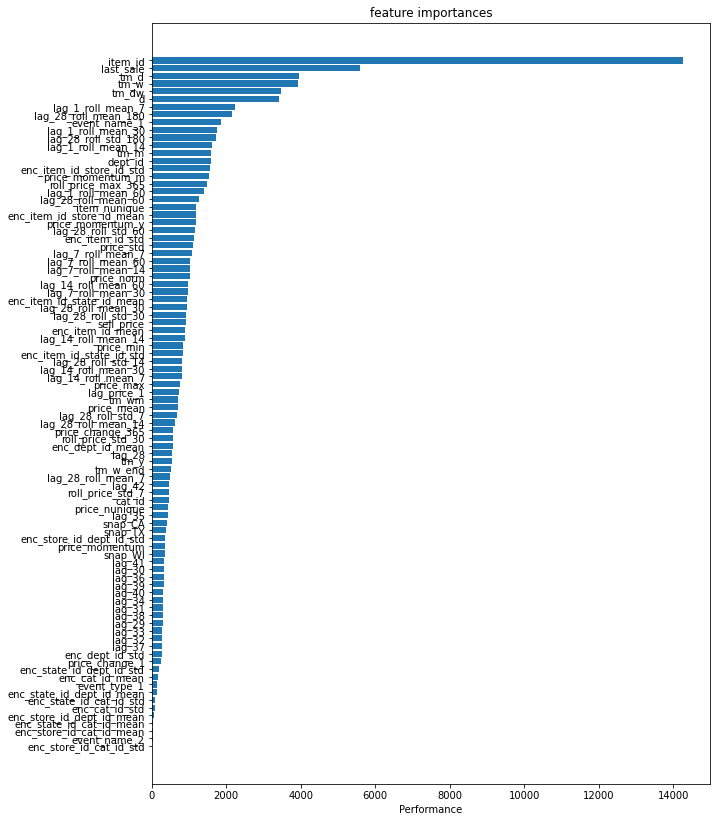

In [33]:
fig, ax = plt.subplots(figsize=(10, 14))
labels, values = [x[0] for x in feat_importances if x[1] > .5], [x[1] for x in feat_importances if x[1] > .5]
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [34]:
%%time
spred = strain[
    (strain['d'] > (END_D - PRED_FWD)) &
    (strain['d'] <= END_D) &
    (strain['store_id'] == store_id)
].copy()
preds = model.predict(spred[train_cols])
print(len(preds))
spred.loc[:, 'sales'] = preds

85372
CPU times: user 14.1 s, sys: 8 ms, total: 14.1 s
Wall time: 809 ms


id to draw: HOUSEHOLD_2_384_CA_1_validation


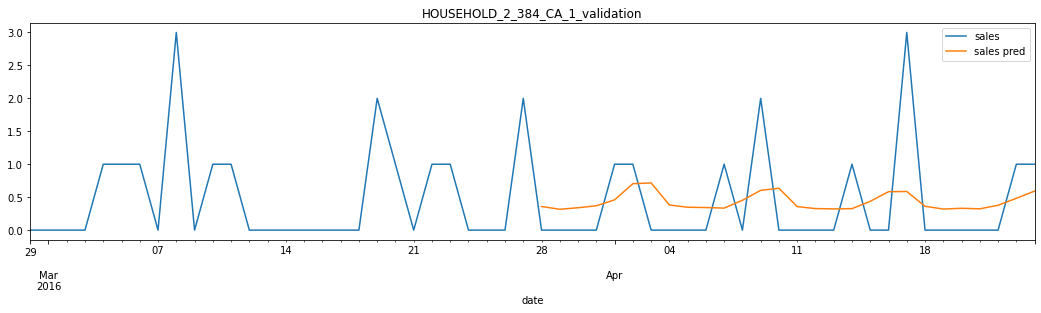

In [35]:
id_name = np.random.choice(strain[strain['store_id'] == store_id]['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - 2 * PRED_FWD)) &
    (strain['d'] <= END_D) &
    (strain['store_id'] == store_id)
].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales pred')
plt.title(id_name)
plt.legend()
plt.show()

In [36]:
for pred_d in tqdm(range(1, PRED_FWD + 1)):
    print('=' * 10, 'forecast day forward:', pred_d, '=' * 10) 
    strain = make_features_last_sales(strain)
    spred = strain[strain['d'] > (END_D - 100)].copy()
    spred = make_features_win(spred)
    for store_id in store_ids:
        model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
        model = lgb.Booster(model_file=model_file)
        strain.loc[
            (strain['d'] == (END_D + pred_d)) & (strain['store_id'] == store_id), 
            'sales'
        ] = model.predict(
            spred.loc[
                (spred['d'] == (END_D + pred_d)) & (spred['store_id'] == store_id), 
                train_cols
            ]
        )
        print('store predicted:', store_id, '| model:', model_file)
    all_sales = strain[strain['d'] == (END_D + pred_d)]['sales'].values
    print('day forward:', END_D + pred_d, 'all sales:', np.sum(all_sales))

========== forecast day forward: 1 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 103)
last non zero sales done
out dataframe: (59181090, 103)
time elapsed: 0 min 48 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 103)
window roll mean sales done
out dataframe: (3902720, 103)
time elapsed: 2 min 46 sec
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1914 all sales: 37328.1767354787
========== forecast 

store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1922 all sales: 45564.75433638196
========== forecast day forward: 10 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 103)
last non zero sales done
out dataframe: (59181090, 103)
time elapsed: 0 min 48 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 103)
window roll mean sales done
out dataframe: (3902720, 103)
time elapsed: 2 min 43 sec
store predicted: 0

store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1930 all sales: 42301.30243322355
========== forecast day forward: 18 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 103)
last non zero sales done
out dataframe: (59181090, 103)
time elapsed: 0 min 48 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 103)
window roll mean sales done
out dataframe: (3902720, 103)
time elapsed: 2 min 44 sec
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6

last non zero sales done
out dataframe: (59181090, 103)
time elapsed: 0 min 49 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 103)
window roll mean sales done
out dataframe: (3902720, 103)
time elapsed: 2 min 44 sec
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1939 all sales: 43736.872440288775
========== forecast day forward: 27 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 103)
last non zero sal

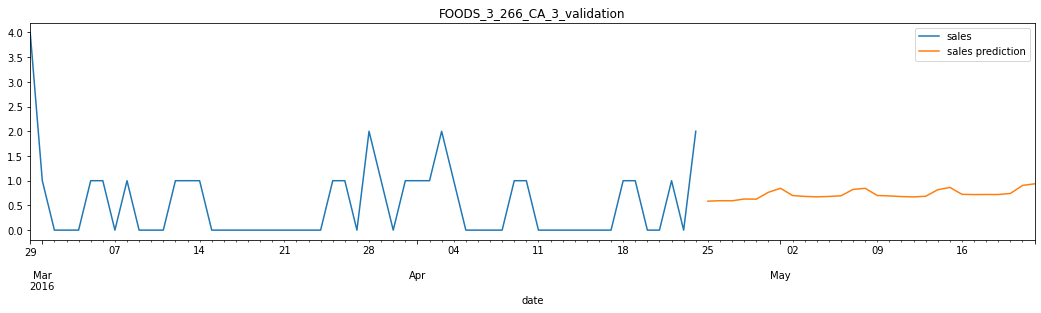

In [44]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - 2 * PRED_FWD)) &
    (strain['d'] <= END_D)
].set_index('date')
id_sales_pred = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > END_D)
].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [38]:
spred_subm = strain.loc[strain['d'] > END_D, ['id', 'd', 'sales']].copy()
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(x - END_D))
spred_subm.loc[spred_subm['sales'] < 0, 'sales'] = 0

In [39]:
f_cols = ['F{}'.format(x) for x in range(1, PRED_FWD + 1)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.840421,0.742778,0.749850,0.774065,0.926721,1.098348,1.028147,0.859293,0.846234,0.882236,0.838313,0.989898,1.078137,0.827374,0.911804,0.814127,0.803776,0.777865,0.915473,1.083677,0.974361,0.858432,0.765417,0.753272,0.731719,0.853424,1.022657,0.959919
1,FOODS_1_001_CA_2_validation,1.207090,1.219932,1.162723,1.189899,1.424043,1.819455,1.920813,1.150145,1.182721,1.164548,1.175025,1.323069,1.655525,1.441531,1.135144,1.143895,1.186570,1.189840,1.410275,1.691274,1.762063,1.159357,1.198100,1.162723,1.212380,1.343851,1.629723,1.772636
2,FOODS_1_001_CA_3_validation,1.023449,1.161593,1.178905,1.220687,1.284931,1.565067,1.683068,1.260908,1.247464,1.310641,1.312229,1.360527,1.650669,1.671153,1.437795,1.373604,1.358460,1.361169,1.413162,1.721925,1.768567,1.456886,1.421208,1.356578,1.361401,1.403712,1.728047,1.842168
3,FOODS_1_001_CA_4_validation,0.378933,0.342038,0.352396,0.341398,0.361836,0.430271,0.421493,0.423660,0.369042,0.374289,0.387582,0.395122,0.436453,0.384670,0.402313,0.377244,0.375658,0.372584,0.384245,0.433901,0.442699,0.413970,0.384268,0.383617,0.370949,0.394307,0.442190,0.436066
4,FOODS_1_001_TX_1_validation,0.063533,0.424058,0.421339,0.420407,0.456784,0.521334,0.619955,0.462173,0.509422,0.489878,0.532900,0.528930,0.634384,0.540271,0.484753,0.464360,0.499136,0.511609,0.514809,0.560484,0.591100,0.487364,0.474596,0.465848,0.471051,0.480937,0.566200,0.583869


In [40]:
spred_subm_eval = spred_subm.copy()
spred_subm_eval['id'] = spred_subm_eval['id'].str.replace('validation', 'evaluation')
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('submission.csv', index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)
